## Stark Broadening Asymmetries From SPY

[The SPY survey](https://ui.adsabs.harvard.edu/abs/2020A%26A...638A.131N/abstract) has a ton of high-res WD spectra. I'm gonna see how much Stark broadening affects their absorption lines.

In [1]:
import glob
import os
import numpy as np

from astropy.io import ascii
from astropy.table import Table
import matplotlib.pyplot as plt
plt.style.use('../../proj/core-composition/notebooks/stefan.mplstyle')

In [2]:
def fetch_files():
    eso_id = ['71.D-0383', '072.D-0487', '165.H-0588', '167.D-0407']
    file_container = {}
    for _id in eso_id:
        data_path = os.path.join('.', 'data', 'raw', _id, '*.fits.Z')
        file_container[_id] = glob.glob(data_path)
    return file_container

In [3]:
from astropy.io import ascii
from astropy.table import Table
import re

def read_spectrum_old(dirpath):
    #objects = Table.read('http://cdsarc.u-strasbg.fr/viz-bin/nph-Cat/fits.gz?J/A+A/638/A131/objects.dat')
    #filenames = objects['FileName'].data
    #filenames = np.array([re.sub(rb'dat', b'dat.gz', s) for s in filenames])
    #objnames = objects['Name'].data
    #fitsdata = {}

    for fname, obj in zip(filenames, objnames):
        dirpath = os.path.abspath('')
        path = os.path.join(dirpath, 'data', 'raw', fname.decode().replace(" ", ""))
        if os.path.isfile(path):
            table = ascii.read(path)
            snr = 20
            if obj.decode() not in fitsdata.keys():
                fitsdata[obj.decode().replace(" ", "")] = [[table['Table'].data, table[':'].data, snr**2 / (table[':'].data)**2]]
            else:
                fitsdata[obj.decode().replace(" ", "")].append([table['Table'].data, table[':'].data, snr**2 / (table[':'].data)**2])
    return objects, fitsdata

obj, fits = read_spectrum()

/tmp/ipykernel_1255/2176070488.py:19: RuntimeWarning: divide by zero encountered in divide
  fitsdata[obj.decode().replace(" ", "")] = [[table['Table'].data, table[':'].data, snr**2 / (table[':'].data)**2]]
/tmp/ipykernel_1255/2176070488.py:21: RuntimeWarning: divide by zero encountered in divide
  fitsdata[obj.decode().replace(" ", "")].append([table['Table'].data, table[':'].data, snr**2 / (table[':'].data)**2])


In [4]:
fits.keys()

dict_keys(['EC12489-2750', 'EC13123-2523', 'HE0031-5525', 'HS0002+1635'])

In [5]:
import corv
from tqdm import tqdm

def test_windows(wl, fl, ivar, n = 10):
    window = dict(a = 15, b = 15,)
    edges = dict(a = 0, b = 0)
    rv_data = []
    windows = []

    steps = np.linspace(0, 85, n)
    for step in tqdm(steps):
        temp_window = window.copy()
        temp_window['a'] += step
        temp_window['b'] += step
        
        corvmodel = corv.models.WarwickDAModel(model_name='1d_da_nlte', names = ['a', 'b'], resolution = 0.0637, windows=temp_window, edges=edges)
        rv, e_rv, redchi, param_res = corv.fit.fit_corv(wl, fl, ivar, corvmodel.model)

        rv_data.append([rv, e_rv, param_res])
        windows.append([temp_window['a'], temp_window['b']])

    return np.array(rv_data), np.array(windows)

def process_results(parameters, windows, plot=True, **kwargs):
    rvs, e_rvs, params = parameters[:,0], parameters[:,1], parameters[:,1]
    windows = windows[:,0]
    diff = rvs - rvs[0]
    significance = lambda rv, e_rv : (rv - rvs[0]) / np.sqrt(e_rv**2 + e_rvs[0]**2)
    sigs = [significance(r, e) for r, e in zip(rvs, e_rvs)]

    if plot:
        fig, (ax1, ax2) = plt.subplots(nrows = 2, figsize=(10,10), **kwargs)
        ax1.errorbar(windows, diff, yerr = e_rvs, fmt='o', c = 'k', markersize=8, capsize=10)
        ax1.axhline(y=0, c='k', ls='--')
        ax1.set_ylabel('$RV - RV_0$ [$km/s]$')

        ax2.scatter(windows, sigs, s = 40, c = 'k')
        ax2.axhline(y=0, c='k', ls='--')
        
        ymin, ymax = ax2.get_ylim()
        if (ymax < 2):
            ax2.set_ylim(ymin,2)
        ymin, ymax = ax2.get_ylim()
        if (ymin > -2):
            ax2.set_ylim(-2, ymax)

        xmin, xmax = ax2.get_xlim()
        ax2.fill_between([xmin,xmax], -1, 1, color='green', alpha=0.5, zorder=0)
        ax2.set_xlim(xmin, xmax)
        ax2.set_ylabel('$\chi^2$ Agreement')
        ax2.set_xlabel(r'Fit Window Size [$\AA$]')

    return np.array(list(zip(windows, diff, e_rvs, sigs)))

<>:50: SyntaxWarning: invalid escape sequence '\c'
<>:50: SyntaxWarning: invalid escape sequence '\c'
/tmp/ipykernel_1255/2432611332.py:50: SyntaxWarning: invalid escape sequence '\c'
  ax2.set_ylabel('$\chi^2$ Agreement')


Could not find the pickled WD models. If you need to use these models, please re-import corv with the proper path.
/Users/vedantchandra/0_research/01_sdss5/006_build_corv/data/comm_cat/
star and exposure catalogs not found! check paths and run make_catalogs() if you want to use sdss functionality. otherwise ignore.


In [6]:
def analyze_spectra(spec_dict):
    results = {}
    for key in spec_dict.keys():
        print(key)
        wl, fl, ivar = fits[key][0]
        parameters, windows = test_windows(wl, fl, ivar)
        results[key] = process_results(parameters, windows, plot=False)
    return results

results = analyze_spectra(fits)

EC12489-2750


  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [01:50<00:00, 11.01s/it]


EC13123-2523


100%|██████████| 10/10 [01:57<00:00, 11.74s/it]


HE0031-5525


100%|██████████| 10/10 [01:22<00:00,  8.26s/it]


HS0002+1635


100%|██████████| 10/10 [01:15<00:00,  7.59s/it]


<>:12: SyntaxWarning: invalid escape sequence '\c'
<>:29: SyntaxWarning: invalid escape sequence '\c'
<>:30: SyntaxWarning: invalid escape sequence '\c'
<>:38: SyntaxWarning: invalid escape sequence '\c'
<>:12: SyntaxWarning: invalid escape sequence '\c'
<>:29: SyntaxWarning: invalid escape sequence '\c'
<>:30: SyntaxWarning: invalid escape sequence '\c'
<>:38: SyntaxWarning: invalid escape sequence '\c'
/tmp/ipykernel_1255/2507066450.py:12: SyntaxWarning: invalid escape sequence '\c'
  ax2.set_ylabel('$\chi^2$ Agreement')
/tmp/ipykernel_1255/2507066450.py:29: SyntaxWarning: invalid escape sequence '\c'
  ax.errorbar(wl, mean_sig, yerr = std_sig, label = f'Mean $\chi^2$ (n = {len(result_dict.keys())})', c = 'k', fmt = 'o', markersize=8, capsize=10)
/tmp/ipykernel_1255/2507066450.py:30: SyntaxWarning: invalid escape sequence '\c'
  ax.scatter(wl, median_sig, label = f'Median $\chi^2$ (n = {len(result_dict.keys())})', c = 'blue', s = 60, zorder=10)
/tmp/ipykernel_1255/2507066450.py:38: S

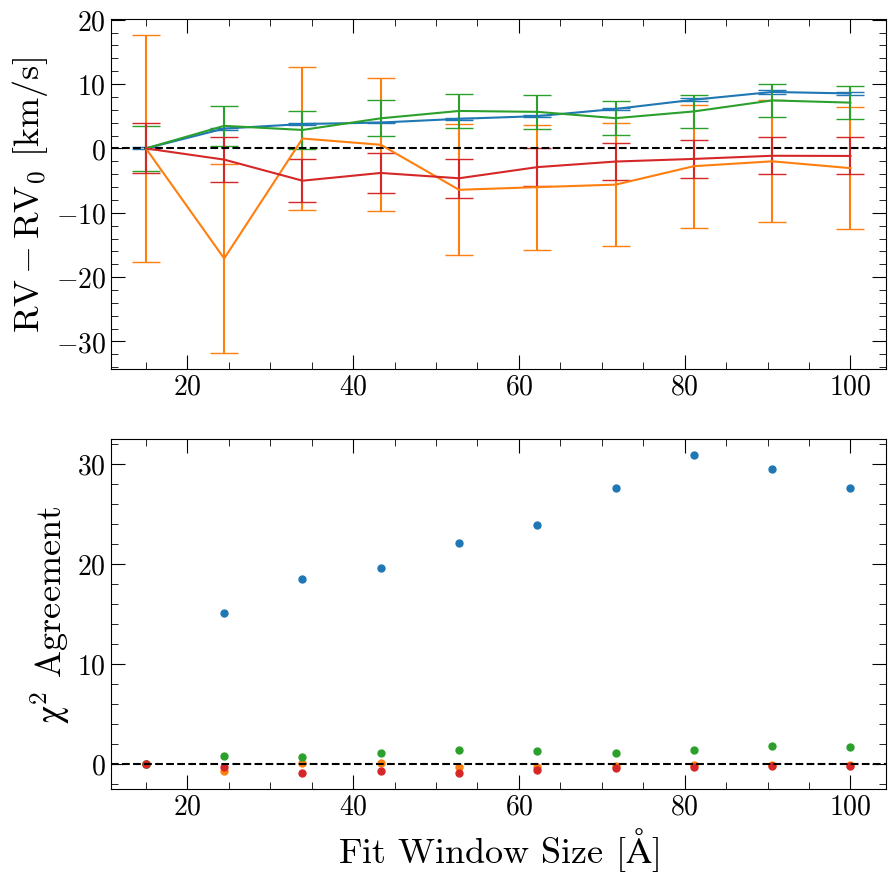

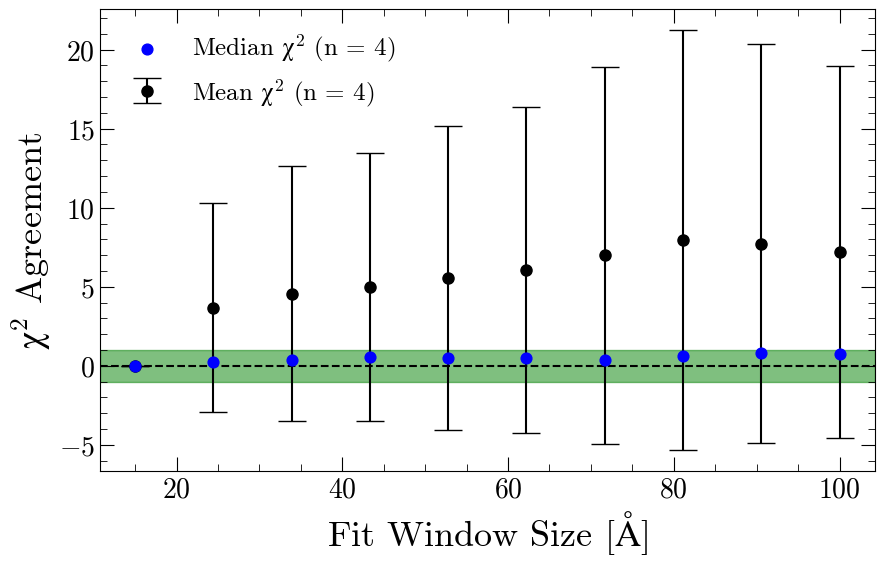

In [9]:
def plot_ensemble(result_dict):
    fig, (ax1, ax2) = plt.subplots(nrows = 2, figsize=(10,10))

    for key in result_dict.keys():
        ax1.errorbar(result_dict[key][:,0], result_dict[key][:,1], yerr = result_dict[key][:,2], markersize=8, capsize=10)
        ax2.scatter(result_dict[key][:,0], result_dict[key][:,3])
    
    ax1.axhline(y = 0, c = 'k', ls = '--')
    ax1.set_ylabel('$RV - RV_0$ [$km/s]$')

    ax2.axhline(y = 0, c = 'k', ls = '--')
    ax2.set_ylabel('$\chi^2$ Agreement')
    ax2.set_xlabel(r'Fit Window Size [$\AA$]')

    fig, ax = plt.subplots(nrows = 1, figsize=(10,6))

    sigs, wls = [], []
    for key in result_dict.keys():
        wls.append(result_dict[key][:,0])
        sigs.append(result_dict[key][:,3])
    sigs = np.array(sigs)

    wl = wls[0]
    mean_sig = np.average(sigs, axis=0)
    median_sig = np.median(sigs, axis=0)
    std_sig = np.std(sigs, axis=0)

    scatter = {'s' : 40}
    ax.errorbar(wl, mean_sig, yerr = std_sig, label = f'Mean $\chi^2$ (n = {len(result_dict.keys())})', c = 'k', fmt = 'o', markersize=8, capsize=10)
    ax.scatter(wl, median_sig, label = f'Median $\chi^2$ (n = {len(result_dict.keys())})', c = 'blue', s = 60, zorder=10)

    xmin, xmax = ax.get_xlim()
    ax.fill_between([xmin,xmax], -1, 1, color='green', alpha=0.5, zorder=0)
    ax.set_xlim(xmin, xmax)
    ax.axhline(y = 0, c = 'k', ls = '--')
    
    ax.set_xlabel(r'Fit Window Size [$\AA$]')
    ax.set_ylabel('$\chi^2$ Agreement')
    ax.legend(framealpha=0)

plot_ensemble(results)